# Poker Parser

- luck: number won at showdown 

### Import functions

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz
import funcs

def find(s, ch):
    return np.array([i for i, ltr in enumerate(s) if ltr == ch]).astype(int)

### Load and process data

In [2]:
dfraw = pd.read_csv('../data/sheff_crew/data_18_02_21.csv').reset_index(drop=True)
df = dfraw[dfraw['entry'].str.contains('Player stacks')].reset_index(drop=False)
df = df.rename(columns={'index':'original_index'})
df = df.drop(columns={'order'})

df = df[::-1].reset_index(drop=True)

In [3]:
# Get names

for irow in range(len(df)):
    s = df.loc[irow,'entry']
    name_starts = find(s,'"')[::2]+1
    name_ends   = find(s,'@')-1
    num_starts  = find(s,'(')+1
    num_ends    = find(s,')')
    for iname in range(len(name_starts)):
        name = s[name_starts[iname]:name_ends[iname]]
        num  = s[num_starts[iname]:num_ends[iname]]
        df.loc[irow,name] = float(num)

names = [n for n in df.columns if n not in ['entry','at','order','original_index']]

In [4]:
df = funcs.get_totals(dfraw, names)

In [7]:
def get_buyins(dfraw, names):
    out = {n:0 for n in names}
    dfi = dfraw[::-1]
    for i, row in dfi.iterrows():
        for n in names:
            if n in row['entry'] and 'joined' in row['entry']:
                out[n] = get_number(row['entry'])
        if set(out.keys())==set(names):
            break
    return out

In [14]:
for i, row in dfraw[::-1].iterrows():
    if i<1200: break
    print(row['entry'])

The player "Dr Hurst @ b7rmnGbpoR" requested a seat.
The admin approved the player "Dr Hurst @ b7rmnGbpoR" participation with a stack of 10.
The admin updated the player "Dr Hurst @ b7rmnGbpoR" stack from 0.10 to 10.10.
The admin updated the player "Dr Hurst @ b7rmnGbpoR" stack from 10.10 to 10.00.
The player "Kristo @ HZl0mGrMth" requested a seat.
The admin approved the player "Kristo @ HZl0mGrMth" participation with a stack of 10.00.
The player "Scott @ Ce3DFmEur5" requested a seat.
The admin approved the player "Scott @ Ce3DFmEur5" participation with a stack of 10.00.
-- starting hand #1  (No Limit Texas Hold'em) (dealer: "Dr Hurst @ b7rmnGbpoR") --
The player "Scott @ Ce3DFmEur5" joined the game with a stack of 10.00.
The player "Dr Hurst @ b7rmnGbpoR" joined the game with a stack of 10.00.
The player "Kristo @ HZl0mGrMth" joined the game with a stack of 10.00.
Player stacks: #2 "Scott @ Ce3DFmEur5" (10.00) | #6 "Dr Hurst @ b7rmnGbpoR" (10.00) | #10 "Kristo @ HZl0mGrMth" (10.00)
Yo

In [6]:
funcs.get_buyins(dfraw, names)

{'Scott': 0, 'Dr Hurst': 0, 'Kristo': 0}

### Colour tester

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)] 



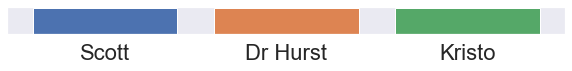

In [29]:
from matplotlib import colors as mcolors
cols = list(mcolors.CSS4_COLORS.keys())
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
cols = [c for c in cols if 'white' not in c]
#np.random.shuffle(cols)

# Suggested colour scheme. Comment this line out to try random schemes.
# cols = ['darkmagenta', 'forestgreen', 'coral', 'darkturquoise','grey']

plt.figure(figsize=[10,0.5])
for i,n in enumerate(names):
    plt.bar([names[i]], [1], color=cols[i])
    plt.xticks(rotation=0);
    plt.yticks([]);
print(cols[:len(names)], '\n')

# Some good colour schemes
# cols = ['mediumturquoise', 'grey', 'red', 'darkmagenta']
# cols = ['forestgreen', 'orange', 'purple', 'cornflowerblue']
# cols = ['darkmagenta', 'forestgreen', 'coral', 'darkturquoise']

### Plot total bankroll over time

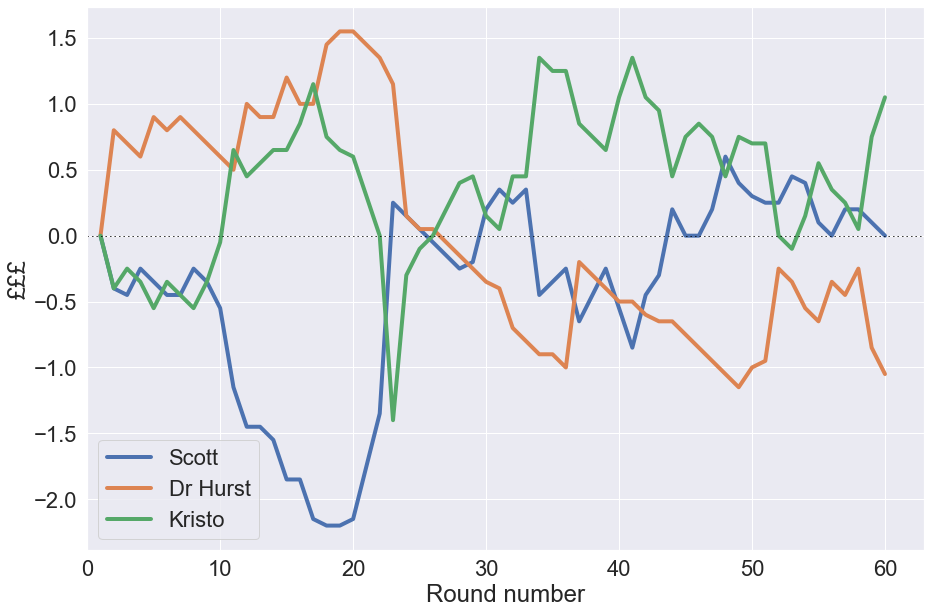

In [30]:
plt.figure(figsize=[15,10])
sns.set(font_scale=2)
for i,n in enumerate(names):
    plt.plot(np.arange(1,len(df)+1),df[n].values,label=n,color=cols[i],linewidth=4)
plt.legend()
plt.xlabel('Round number')
plt.ylabel('£££')
plt.xlim(left=0);
plt.gca().axhline(0,dashes=[3,6],linewidth=.5,color='black')
plt.gca().axhline(df.loc[0,names[0]],dashes=[3,6],linewidth=.5,color='black')

plt.savefig(f'poker_{datetime.now().strftime("%d_%m_%y")}.png',bbox_inches='tight')

### Plot winnings and losses per round

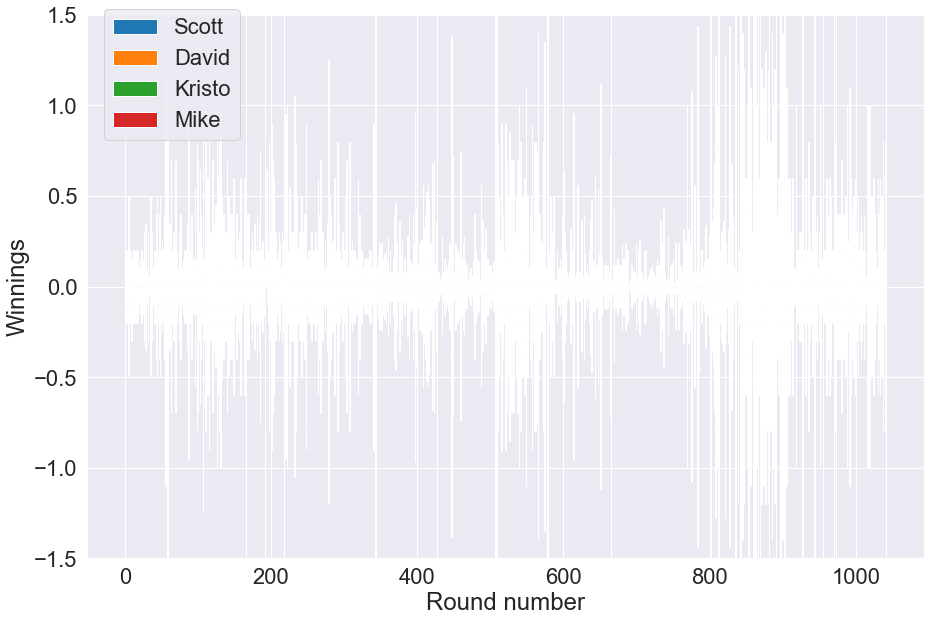

In [11]:
plt.figure(figsize=[15,10])
sns.set(font_scale=2)

previous = (np.arange(1,len(df))*0).astype(float)
for i,n in enumerate(names):
    diffs = np.diff(df[n])

    above_part = np.where(diffs>0, diffs, 0)
    plt.bar(np.arange(1,len(df)),above_part,color=cols[i], label=n, alpha=1)

    bottom_part = np.diff(df[n])
    bottom_part = np.where(diffs<0, -diffs, 0)
    previous-=bottom_part

    inds = np.where(bottom_part!=0)[0]
    y_plot = bottom_part[inds]
    x_plot = np.arange(1,len(df))[inds] 
    plt.bar(x_plot,y_plot,bottom=previous[inds],color=cols[i], alpha=1)


plt.legend(loc=[0.02,.77])
plt.xlabel('Round number')
plt.ylabel('Winnings')
range_ = 1.5

plt.ylim((-range_,range_));

#plt.savefig(f'winnings_{datetime.now().strftime("%d_%m_%y")}.png',bbox_inches='tight')

### Who won at which parts?

In [25]:
entries = dfraw['entry'][::-1]

all_hands = []
hand = []
active = 0
for i,e in enumerate(entries):
    if active and '--' not in e:
        hand.append(e)
    if '-- starting hand' in e:
        starter = i
        active = 1
    if '-- ending hand' in e:
        active = 0
        all_hands.append(hand)
        hand = []

In [27]:
def get_winner(hand,names):
    for row in hand:
        if 'collected' in row:
            for n in names:
                if n in row:
                    return n

def get_section(hand):
    for sec in ['River','Turn','Flop']:
        if sec in ' '.join(hand):
            return sec
    return 'Preflop'

def get_round_wins(dfraw):
    entries = dfraw['entry'][::-1]

    all_hands = []
    hand = []
    active = 0
    for i,e in enumerate(entries):
        if active and '--' not in e:
            hand.append(e)
        if '-- starting hand' in e:
            starter = i
            active = 1
        if '-- ending hand' in e:
            active = 0
            all_hands.append(hand)
            hand = []

    win_on = pd.DataFrame({
        'Name':names,
        'Preflop':[0]*len(names),
        'Flop':[0]*len(names),
        'Turn':[0]*len(names),
        'River':[0]*len(names),
    })

    win_on = win_on.set_index('Name')

    for h in all_hands:
        winner  = get_winner(h,names)
        section = get_section(h)
        win_on.loc[winner,section] += 1

    win_on = win_on.reset_index(drop=False)
    
    win_on_perc = win_on.copy()[['Preflop','Flop','Turn','River']]
    totals = win_on_perc.sum(axis=1)
    for i in range(len(win_on_perc)):
        win_on_perc.loc[i,:] = 100*win_on_perc.loc[i,:]/totals[i]
    win_on_perc['Name'] = names
    
    return win_on, win_on_perc

win_on, win_on_perc = get_round_wins(dfraw)

In [28]:
def bar_plotter(df, save=True, perc=False):
    plt.figure(figsize=(10,5))
    sns.set(font_scale=2)
    
    rounds = [c for c in df.columns if c!='Name']
    names = list(df['Name'].values)
    
    main_ticks = np.arange(len(rounds))
    jump = 1/(len(names)+1)
    
    for i, n in enumerate(names):
        xpos = main_ticks + jump*i
        
        data_to_plot = [df.loc[df['Name']==n, r].values[0] for r in rounds]
        
        plt.bar(
            xpos,
            data_to_plot,
            width=jump*0.9,
            label=n.title(),
            color=cols[i]
        )
        
    if perc:
        plt.ylabel('Percentage rounds won for player')
    else:
        plt.ylabel('Rounds won')
    plt.gca().set_xticks(main_ticks + jump*(i/2))
    plt.gca().set_xticklabels(rounds)
    legend = plt.legend(title='Player', loc=[0.98,0.6])
    plt.setp(legend.get_title(),fontsize=15)
    plt.grid(axis='x')
    if save:
        if perc:
            plt.savefig(f'percrounds_{datetime.now().strftime("%d_%m_%y")}.png',bbox_inches='tight')
        else:
            plt.savefig(f'rounds_{datetime.now().strftime("%d_%m_%y")}.png',bbox_inches='tight')
    plt.show()

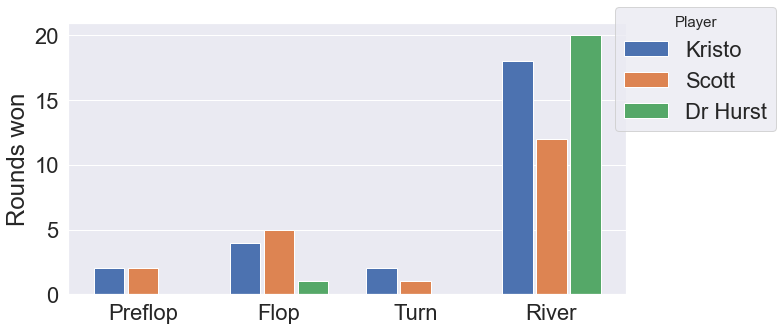

In [30]:
bar_plotter(win_on, save=True, perc=False)

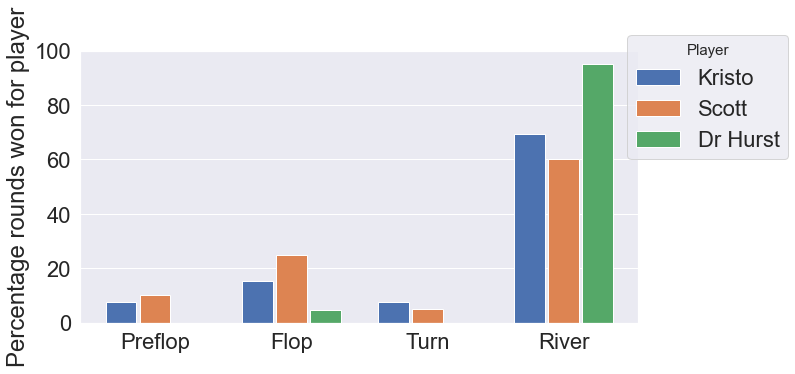

In [31]:
bar_plotter(win_on_perc, save=True, perc=True)

In [20]:
megfold = 0
scottfold = 0

In [21]:
dfraw = dfraw.reset_index(drop=1)

In [22]:
for i in range(len(dfraw)):
    entry = dfraw.loc[i,'entry']
    if 'Meg' in entry and 'fold' in entry:
        megfold +=1
    if 'Scott' in entry and 'fold' in entry:
        scottfold +=1

In [65]:
df[(df.Meg==10)&(df.Scott==10)]

,Meg,Scott,at
0,10.0,10.0,2021-02-06T10:04:06.617Z
36,10.0,10.0,2021-02-06T11:04:26.669Z
45,10.0,10.0,2021-02-06T11:15:34.354Z
67,10.0,10.0,2021-02-06T11:36:48.058Z
73,10.0,10.0,2021-02-06T11:42:09.910Z


In [72]:
df0 = df[0:36]
df1 = df[36:45]
df2 = df[45:67]
df3 = df[67:73]
df4 = df[73:]

In [69]:
df0 = df0.append(pd.DataFrame({'Meg':0,'Scott':20,'at':''}))

,Meg,Scott,at
67,10.0,10.0,2021-02-06T11:36:48.058Z
68,10.4,9.6,2021-02-06T11:37:55.260Z
69,10.6,9.4,2021-02-06T11:38:36.042Z
70,10.4,9.6,2021-02-06T11:39:13.446Z
71,10.8,9.2,2021-02-06T11:39:59.004Z
72,11.8,8.2,2021-02-06T11:40:47.831Z


In [74]:
df1

,Meg,Scott,at
36,10.0,10.0,2021-02-06T11:04:26.669Z
37,10.6,9.4,2021-02-06T11:05:48.119Z
38,10.8,9.2,2021-02-06T11:06:40.658Z
39,10.2,9.8,2021-02-06T11:08:00.422Z
40,10.4,9.6,2021-02-06T11:09:14.600Z
41,10.8,9.2,2021-02-06T11:10:03.397Z
42,11.6,8.4,2021-02-06T11:11:57.066Z
43,11.8,8.2,2021-02-06T11:12:36.551Z
44,11.4,8.6,2021-02-06T11:13:21.194Z


# Global performance

In [8]:
import os
from dateutil.parser import parse as dtparse
from datetime import datetime
import pandas as pd
import parser_script

datalist = os.listdir('../data/sheff_crew')
datalist = [f for f in datalist if 'data' in f and 'mike' not in f]

datalist = [x[5:-4].replace('_','-') for x in datalist]
datalist = sorted(datalist, key = lambda x: datetime.strptime(x, '%d-%m-%y'))
datalist = ['data_'+x.replace('-','_')+'.csv' for x in datalist]

dfall = [pd.read_csv(f'../data/sheff_crew/{x}') for x in datalist]

allnames = [parser_script.get_names(d) for d in dfall]

names = []
for aln in allnames:
    names.extend(aln)
names = list(set(names))

namegroups = [
    ['Scott','Scottyboi','Dr Scott','Dr. Scott'],
    ['David','Dr Hurst','Dr. Hurst'],
    ['Kristo','kris','Kris','Also a DR','Krist'],
    ['Mike','Michael','Dr. Roche']
]

df = parser_script.get_lifetime_performance(dfall, namegroups)
names = [n[0] for n in namegroups]

0
1
2
3
4
5
6
7
8
9
10
11
12


In [4]:
df = dfall.copy()

In [12]:
df

,Scott,David,Kristo,Mike
0,0.00,0.00,0.00,0.00
1,-0.20,0.00,0.00,0.20
2,-0.30,-0.10,0.00,0.40
3,-0.30,-0.15,0.00,0.45
4,-0.25,-0.15,0.00,0.40
...,...,...,...,...
1037,-2.33,-10.71,14.53,0.11
1038,-2.43,-10.71,14.63,0.11
1039,-2.53,-10.51,14.53,0.11
1040,-2.83,-11.01,15.33,0.11


In [17]:
len(np.where(np.diff(df['Mike'])!=0)[0])

672

In [18]:
df

,Scott,David,Kristo,Mike
0,0.00,0.00,0.00,0.00
1,-0.20,0.00,0.00,0.20
2,-0.30,-0.10,0.00,0.40
3,-0.30,-0.15,0.00,0.45
4,-0.25,-0.15,0.00,0.40
...,...,...,...,...
1037,-2.33,-10.71,14.53,0.11
1038,-2.43,-10.71,14.63,0.11
1039,-2.53,-10.51,14.53,0.11
1040,-2.83,-11.01,15.33,0.11
